# Exploratory Data Analysis

In [269]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0  , 0  , 0  ),
        (230, 25 , 75 ),
        (60 , 180, 75 ),
        (255, 225, 25 ),
        (0  , 130, 200),
        (145, 30 , 180),
        (70 , 240, 240),
        (240, 50 , 230),
        (210, 245, 60 ),
        (250, 190, 190),
        (0  , 128, 128),
        (170, 110, 40 ),
        (255, 250, 200),
        (128, 0  , 0  ),
        (170, 255, 195),
        (128, 128, 0  ),
        (255, 215, 180),
        (0  , 0  , 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

In [271]:
import pandas as pd
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

PATH = ''
def get_dfs(sample_fraction=1):
    train_df = load_and_sample_data(PATH + 'train.csv', sample_fraction)
    val_df   = load_and_sample_data(PATH + 'val.csv'  , sample_fraction)
    test_df  = load_and_sample_data(PATH + 'test.csv' , sample_fraction)
    return (train_df, val_df, test_df)

train_df, val_df, test_df = get_dfs(1)

In [258]:
import os
BIN_PATH = 'bin/'
if not os.path.exists(BIN_PATH):
    os.makedirs(BIN_PATH)

### Plotting helpers

In [259]:
def plot_distribution(distribution, title, classes, save=True):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(distribution)), distribution, tick_label=[
        f'{classes[i]}' for i in range(len(distribution))
    ])
    plt.xlabel('Class')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log')
    plt.title(title)
    plt.xticks(rotation=75)
    if save:
        plt.savefig(BIN_PATH + title)
    plt.show()


def plot_folder_distributions(
    folder_labels, title, subtitles, labels, axis_factor=None, font_factor=1, save=True
):
    # row, column, and factoring
    total = len(folder_labels)
    cols  = 2
    rows  = total//cols + 1 if total > cols else 1
    if axis_factor is None:
        axis_factor = 2.2 if rows == 1 else 1.2*(rows-1)

    # figure and axis
    fig, ax = plt.subplots(rows, cols, figsize=(15*axis_factor, 15))
    fig.suptitle(title, fontsize=25*font_factor)
    fig.text(0.5, 0.04, 'Class', ha='center', fontsize=15)
    fig.text(0.06, 0.5, 'Frequency (log scale)', va='center', rotation='vertical', fontsize=15)

    # legend
    legend_labels  = [f'{i}: {labels[i]}' for i in range(len(labels))]
    legend_handles = [plt.Rectangle((0,0), 0, 0, alpha=0.0) for _ in labels]
    fig.legend(legend_handles, legend_labels, loc='lower right', prop={'size': 12})

    # distribution for each folder
    for i in range(cols*rows):
        ax_i = ax[i] if rows == 1 else ax[i//cols, i%cols]
        if i >= total:
            ax_i.axis('off')
            continue # leave blank rather than stop
        distribution = folder_labels[i]
        ax_i.bar(range(len(distribution)), distribution, tick_label=[
            f'{i}' for i in range(len(distribution))
        ])
        if np.any(distribution != 0):
            ax_i.set_yscale('log')
        ax_i.set_title(subtitles[i], fontsize=17*font_factor)

    if save:
        fig.savefig(BIN_PATH + title)

### Label distribution helpers

In [146]:
def label_arr(df):
    return np.array(df['label_path'])

def label_distributions(classes, path=None, arr=None):
    assert not path is None or not arr is None
    n = len(classes)
    labels = np.zeros((n,))
    if type(arr) != np.ndarray:
        arr = np.array(arr)
    paths = arr if path is None else os.listdir(path)
    for i, label_path in enumerate(paths):
        label = cv2.imread(label_path, -1)
        labels += np.bincount(label.flatten(), minlength=n)
    return labels


# Specific to folder distribution
def filter_by_subdirectories(paths, subdirectories, indx=1, delim='/'):
    ret = [None] * len(subdirectories)
    extract_subdirectory = np.vectorize(
        lambda paths, delim: np.char.split(paths, delim)
    )
    split_paths = extract_subdirectory(paths, delim)
    subdir_arr  = np.array([path.tolist()[indx] for path in split_paths])
    for i, subdirectory in enumerate(subdirectories):
        ret[i] = paths[subdir_arr == subdirectory]
    return ret

# Global distributions

In [6]:
val_labels     = label_distributions(METAINFO['classes'], arr=label_arr(val_df  ))
train_labels   = label_distributions(METAINFO['classes'], arr=label_arr(train_df))
test_labels    = label_distributions(METAINFO['classes'], arr=label_arr(test_df ))
dataset_labels = val_labels + train_labels + test_labels

### **Training label distribution**

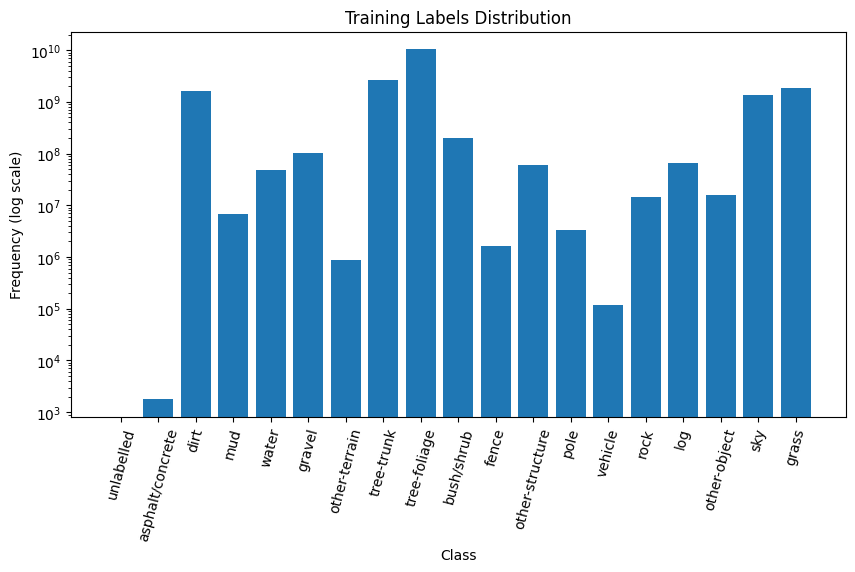

In [262]:
plot_distribution(train_labels, 'Training Labels Distribution', METAINFO['classes'])

### **Validating label distribution**

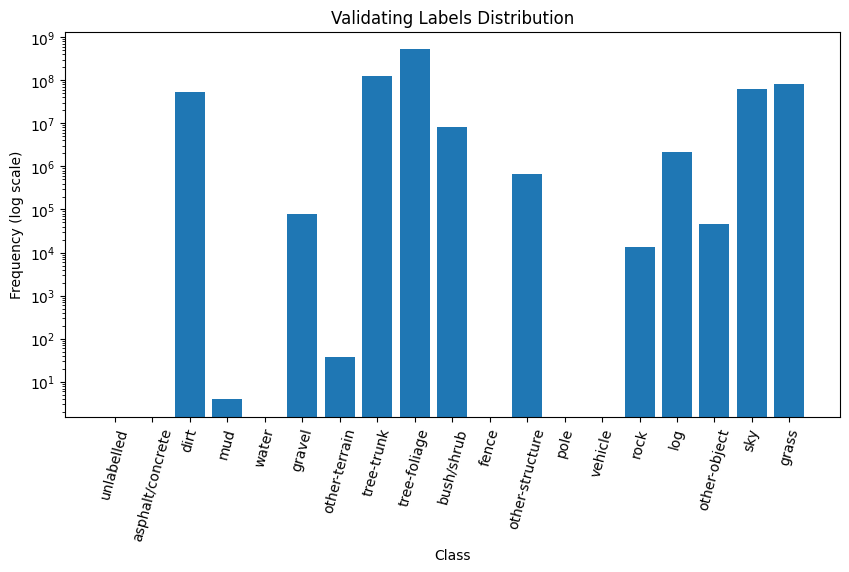

In [263]:
plot_distribution(val_labels, 'Validating Labels Distribution', METAINFO['classes'])

### **Testing label distribution**

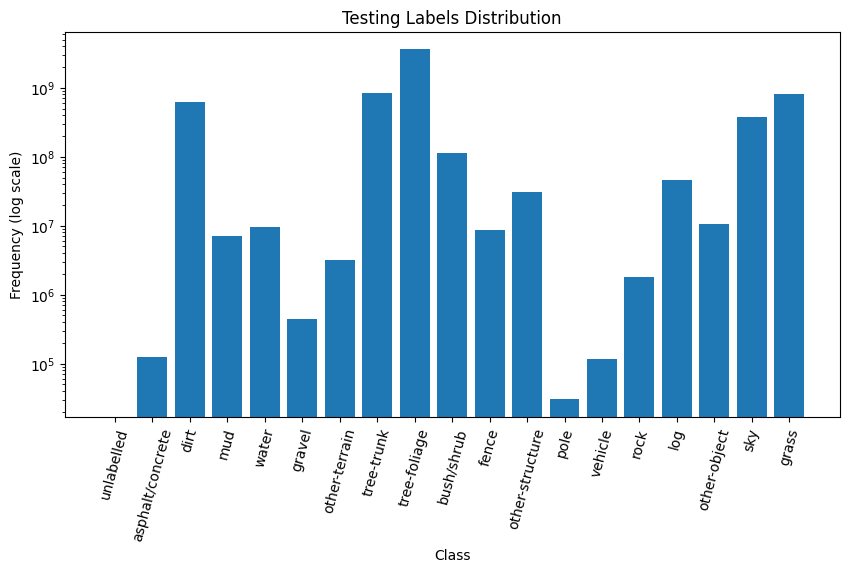

In [264]:
plot_distribution(test_labels, 'Testing Labels Distribution', METAINFO['classes'])

### **Dataset label distribution**

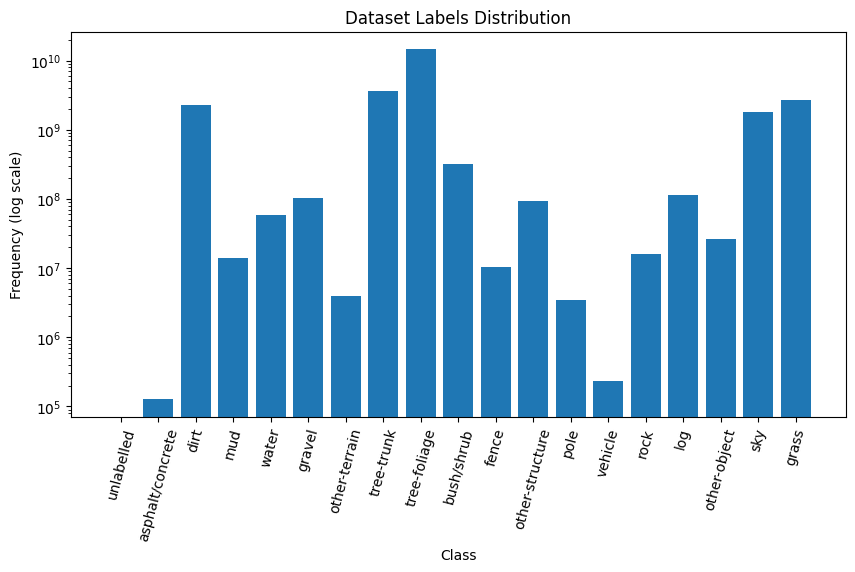

In [265]:
plot_distribution(dataset_labels, 'Dataset Labels Distribution', METAINFO['classes'])

### Commentary

Should be on how the split retains the dataset distribution among each subset (and possibly that it is indeed random, if it can even be proven - or at least a split process should be cited), especially train - since retaining distribution in train meant that the training data is most representative of the original data. Testing set retaining the distribution is also important, since it meant the performance evaluation is also the most representative.

# Folder distributions

In [27]:
def get_folder_labels(folders):
    folder_labels = [None] * len(folders)
    for i, folder in enumerate(folders):
        folder_labels[i] = label_distributions(METAINFO['classes'], arr=folder)
    return folder_labels

In [ ]:
subdirectories = ['K-01', 'K-03', 'V-01', 'V-02', 'V-03']
train_folders = filter_by_subdirectories(np.array(train_df['label_path']), subdirectories)
val_folders   = filter_by_subdirectories(np.array(val_df  ['label_path']), subdirectories)
test_folders  = filter_by_subdirectories(np.array(test_df ['label_path']), subdirectories)

train_folder_labels = get_folder_labels(train_folders)
val_folder_labels   = get_folder_labels(val_folders  )
test_folder_labels  = get_folder_labels(test_folders )

id_labels = {i: e for i, e in enumerate(METAINFO['classes'])}

### **Training distribution by folder**

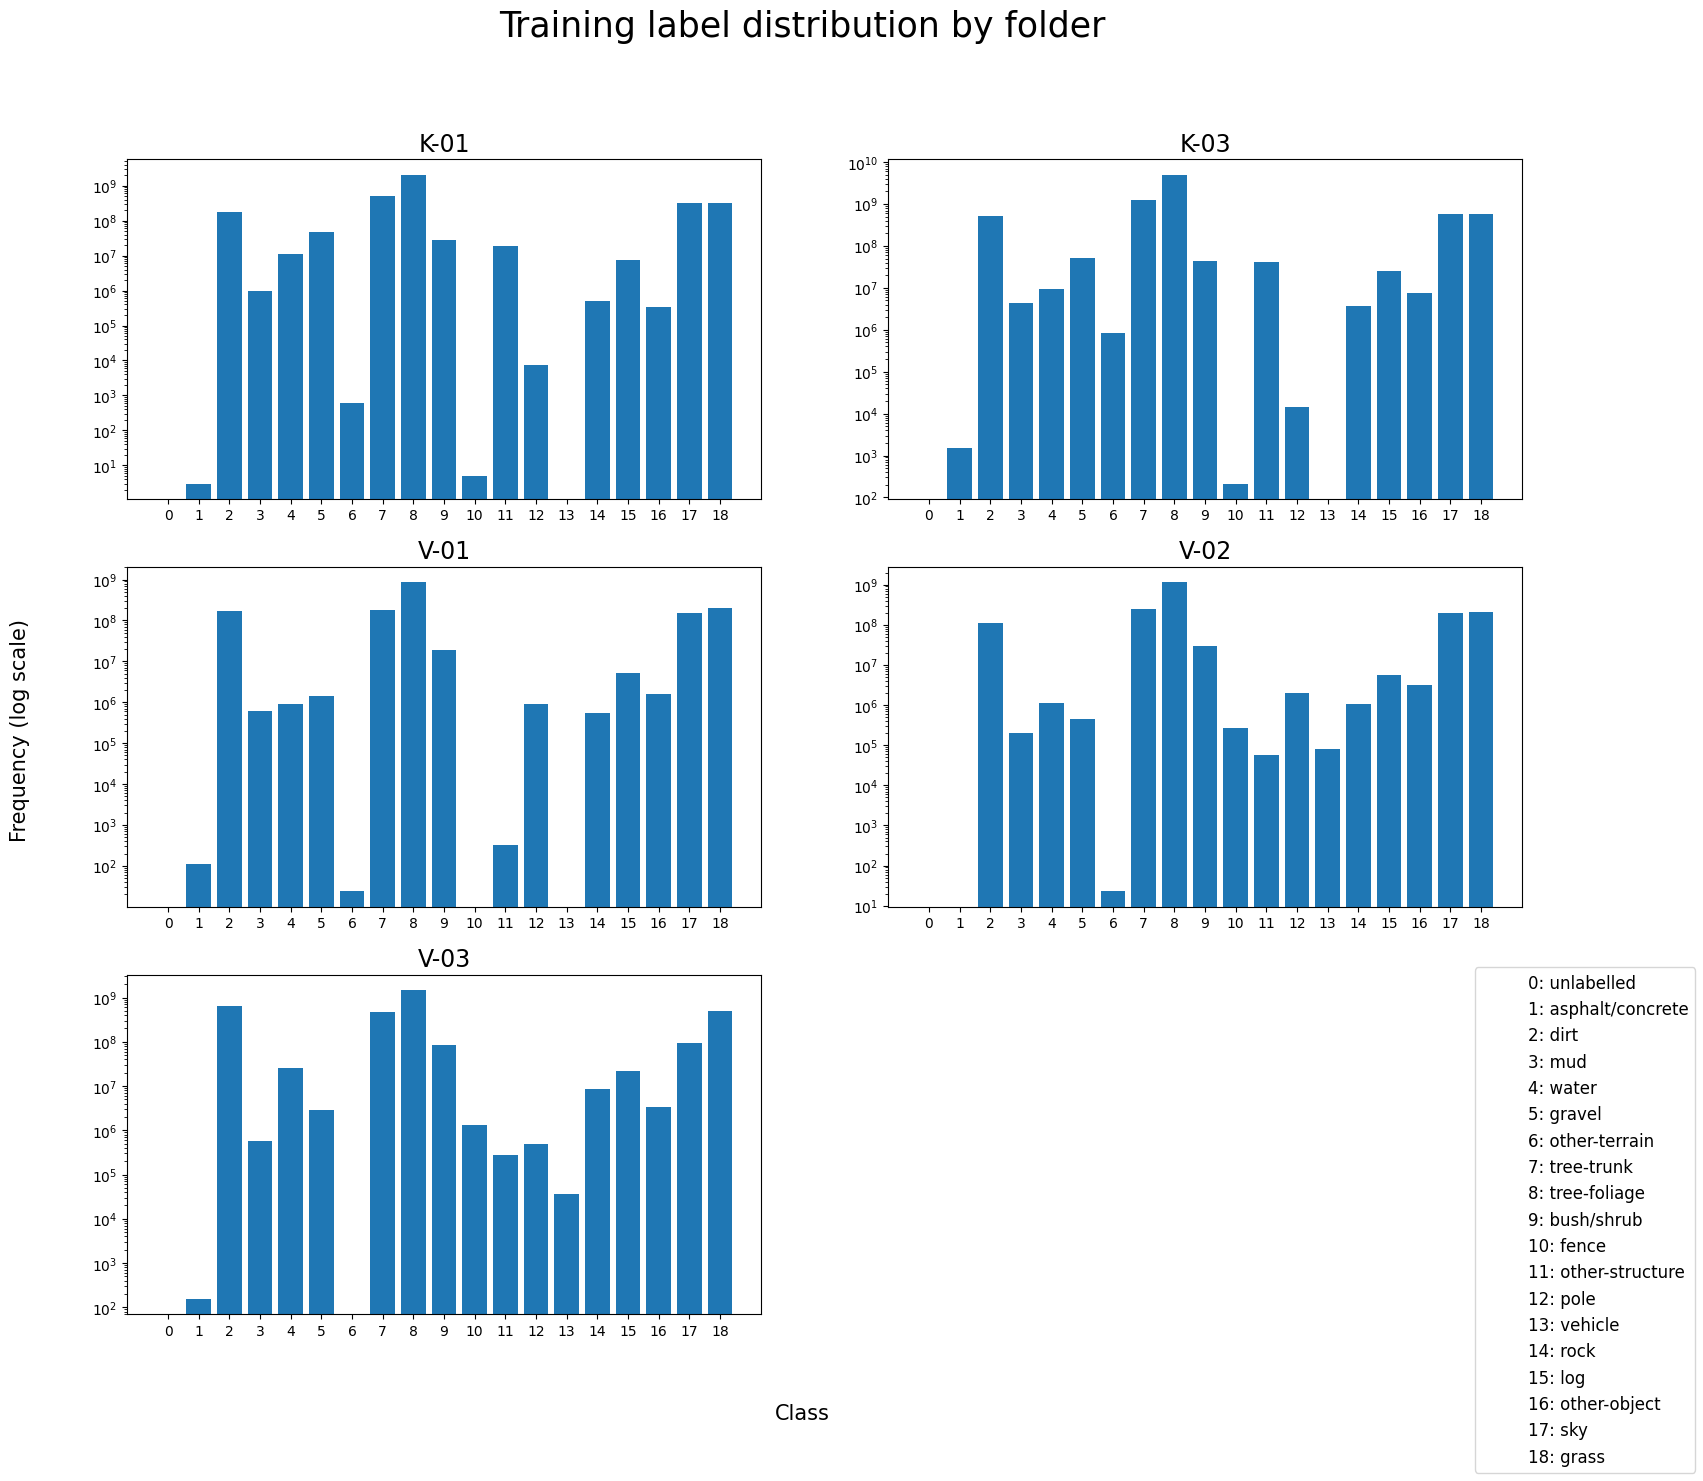

In [266]:
plot_folder_distributions(
    train_folder_labels,
    "Training label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    axis_factor=1.2,
)

### **Validating distribution by folder**

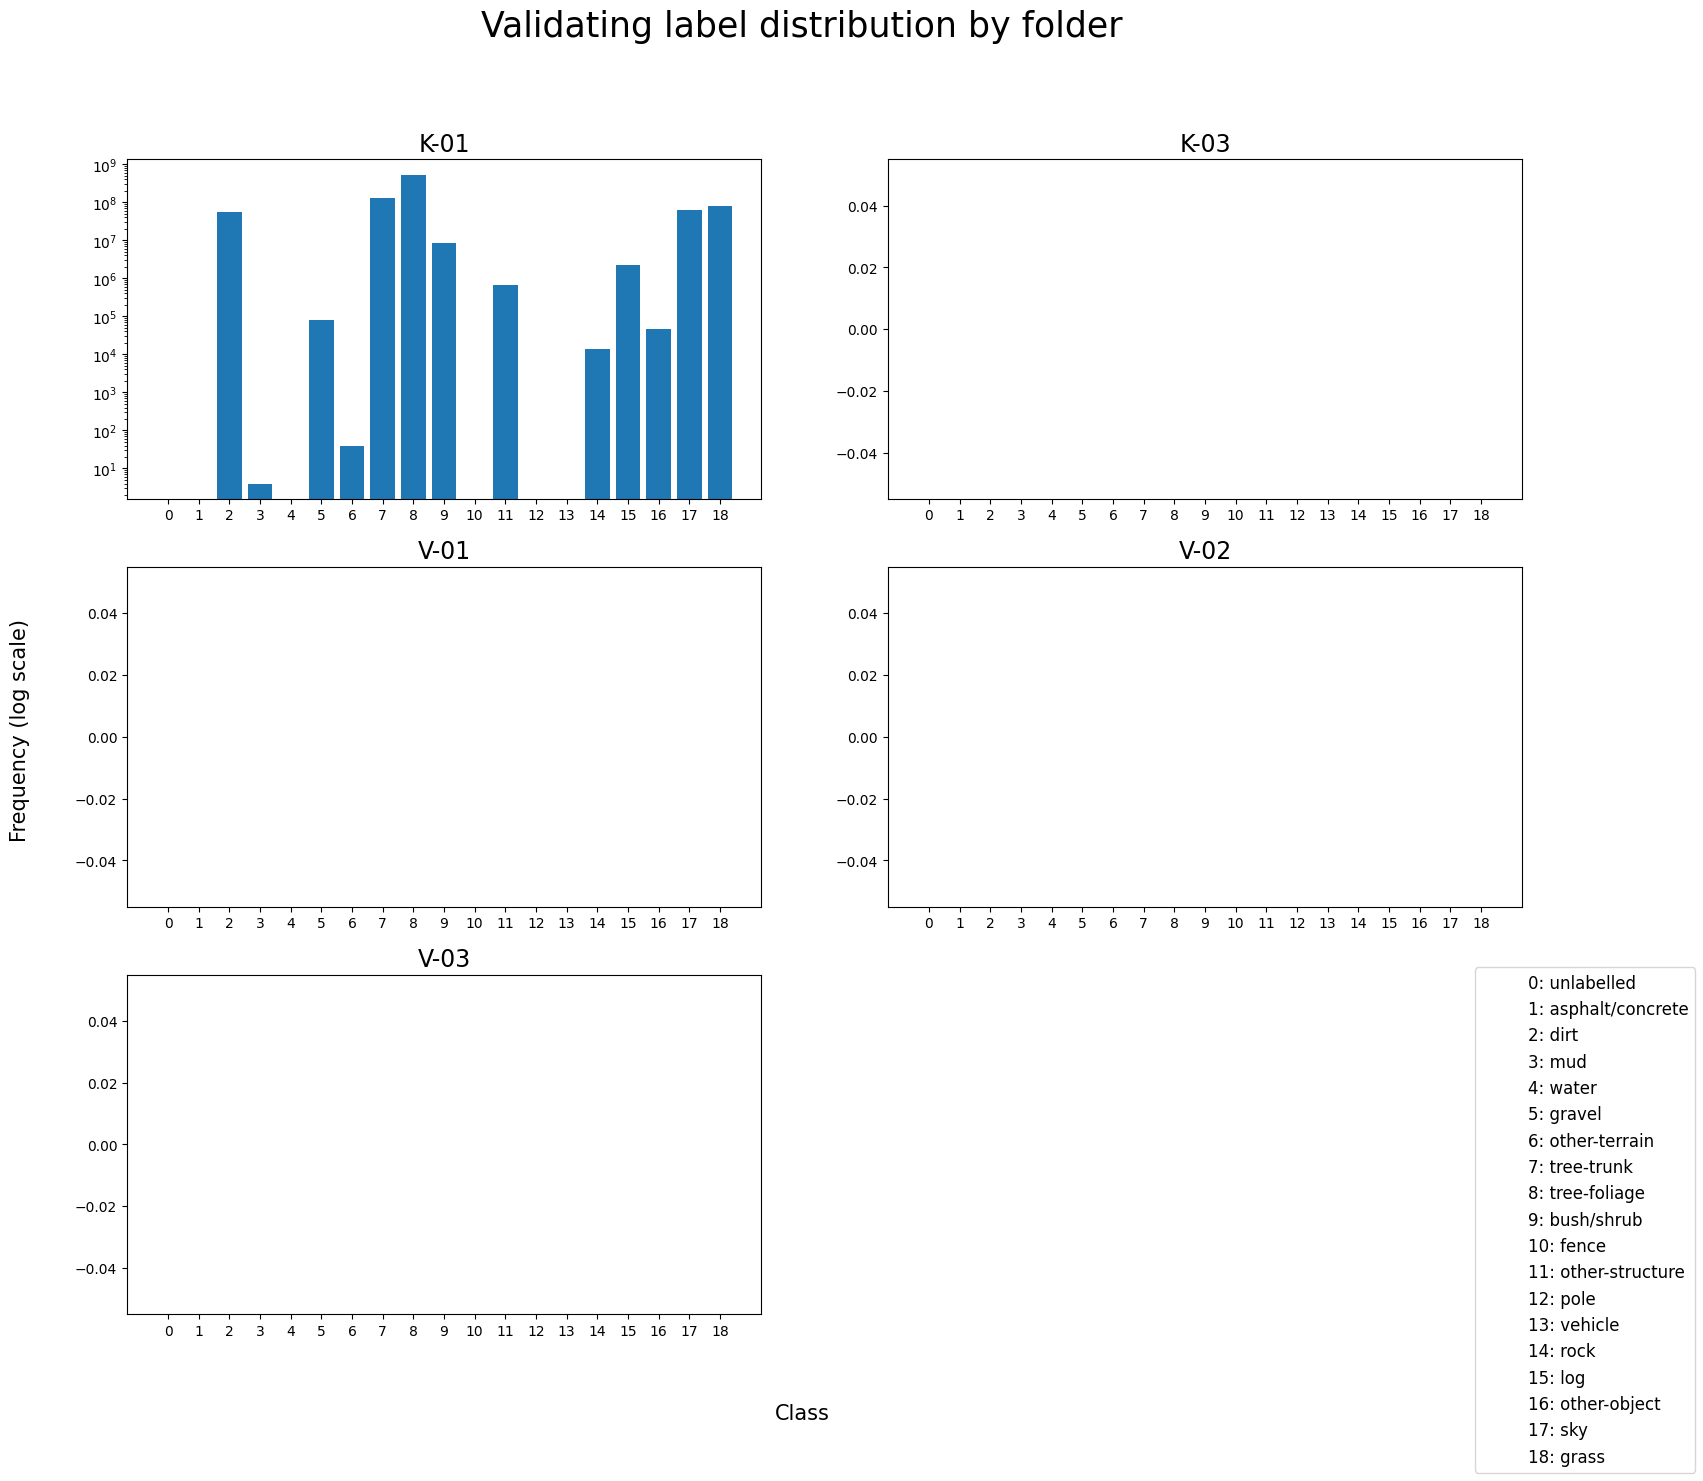

In [267]:
plot_folder_distributions(
    val_folder_labels,
    "Validating label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    axis_factor=1.2,
)

### **Testing distribution by folder**

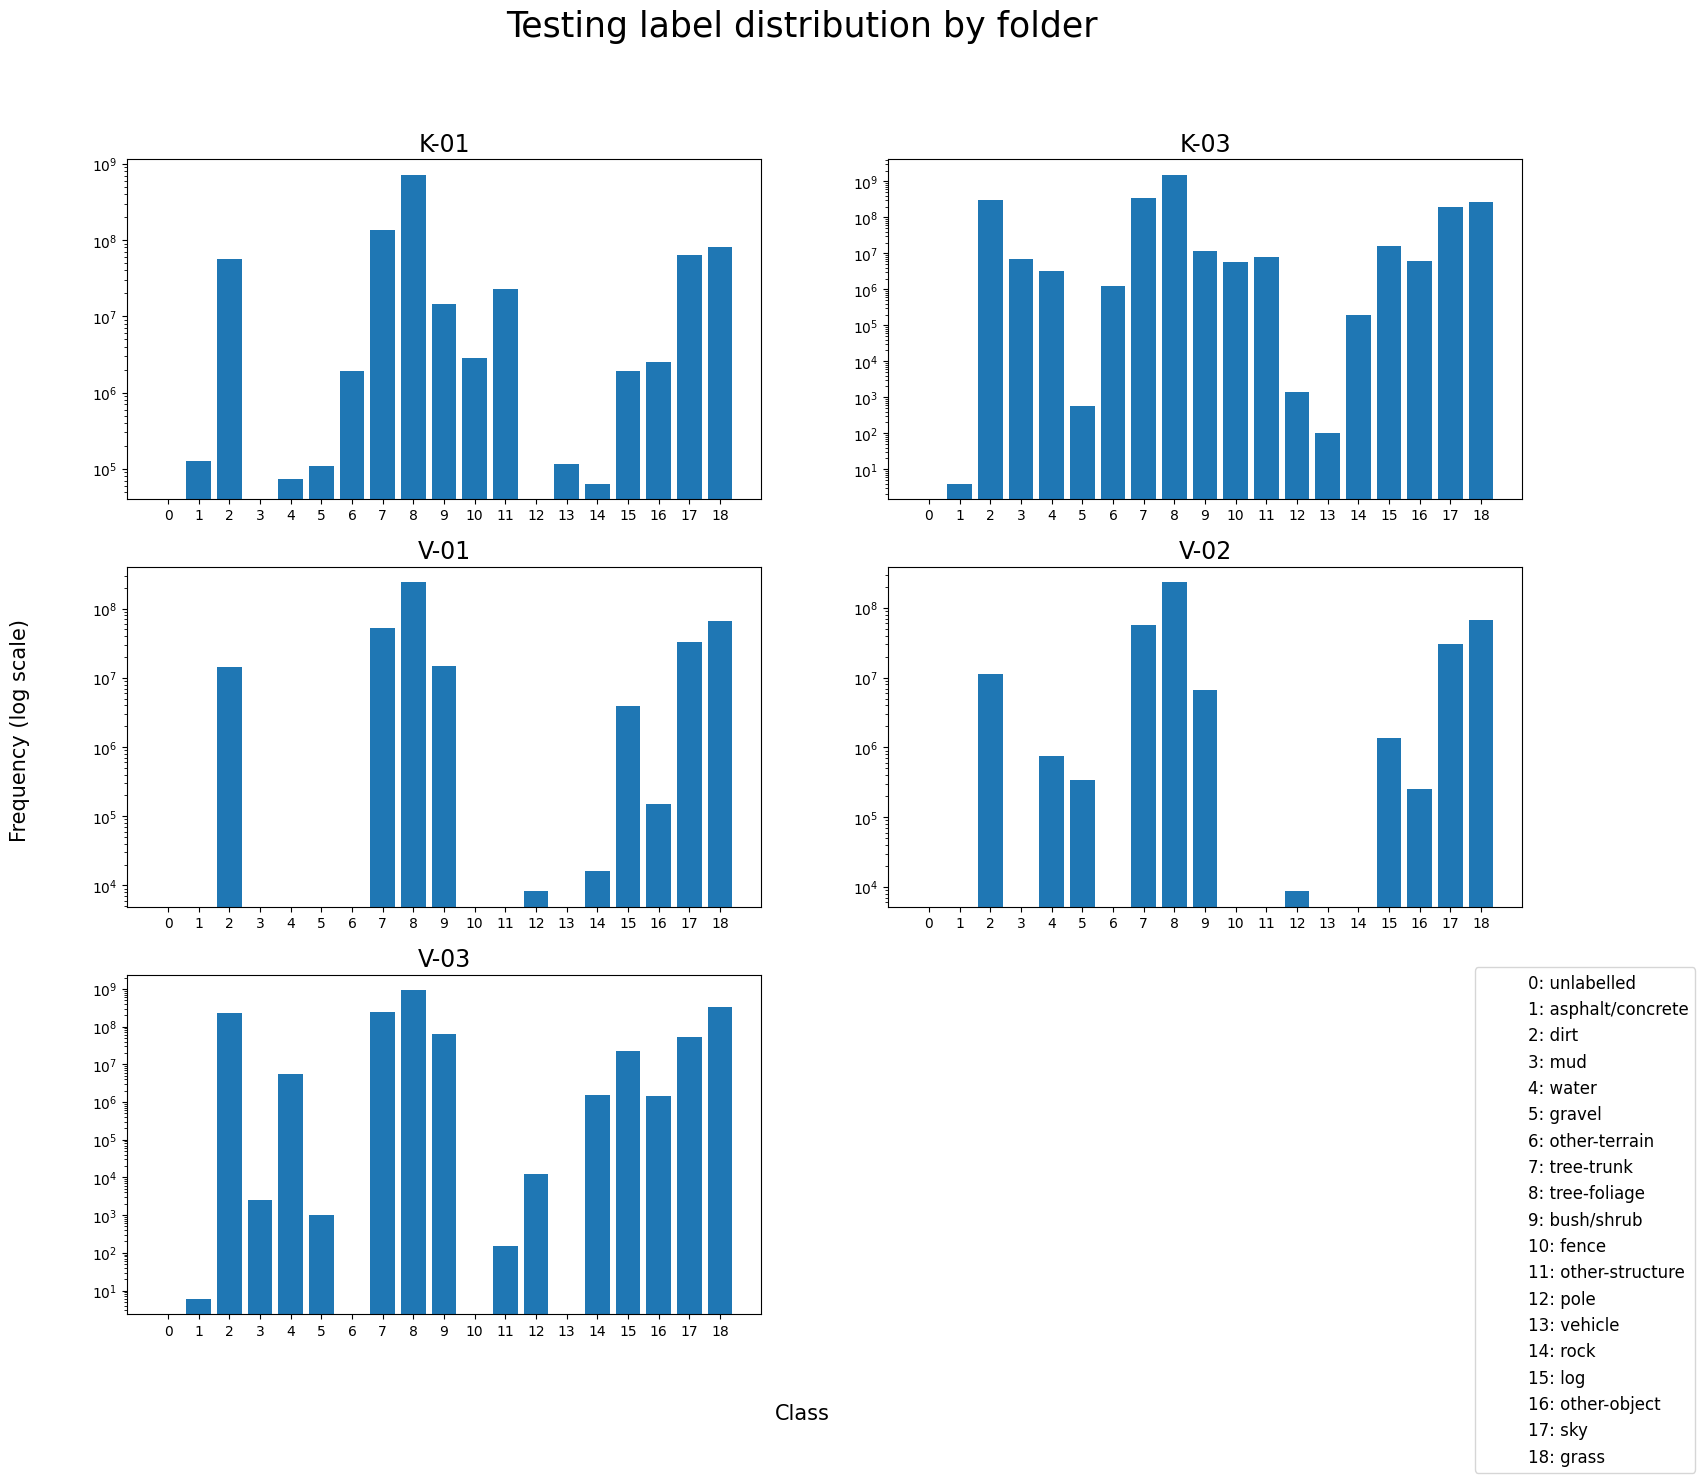

In [268]:
plot_folder_distributions(
    test_folder_labels,
    "Testing label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    axis_factor=1.2,
)